In [1]:
import numpy as np
from sklearn.datasets import load_files
from glob import glob
from keras.utils import np_utils
import keras

Using TensorFlow backend.


In [2]:
def load_dataset(path):
    data = load_files(path, shuffle=False)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), None)
    return files, targets

train_files, train_targets = load_dataset("dataset/training_set")
test_files, test_targets = load_dataset("dataset/test_set")
valid_files, valid_targets = load_dataset("dataset/validation_set")

n = [i[22:-2].upper() for i in sorted(glob('dataset//training_set//*//'))]

print('There are {} categories - [{}, {}]'.format(len(n), n[0], n[1]))
print('Total {} images'.format(len(np.hstack([train_files, test_files, valid_files]))))
print('-> {} training images'.format(len(train_files)))
print('-> {} validation images'.format(len(valid_files)))
print('-> {} testing images'.format(len(test_files)))

There are 2 categories - [CAT, DOG]
Total 10000 images
-> 6000 training images
-> 2000 validation images
-> 2000 testing images


In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (128, 128, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 128, 128, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [4]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 2000/2000 [00:05<00:00, 389.98it/s]


In [5]:
from keras.preprocessing.image import ImageDataGenerator as idg

datagen = idg(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(train_tensors)

In [59]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(32, (3,3), strides= (1,1), padding='same', activation='relu', input_shape=train_tensors[0].shape))
model.add(Conv2D(32, (3,3), strides= (1,1) ,padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides = None))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), strides= (1,1) ,padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), strides= (1,1) ,padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides = None))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(n), activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [60]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
from keras.callbacks import ModelCheckpoint   

batch_size = 64
epochs = 30

checkpointer = ModelCheckpoint(filepath='best_aug', verbose=1, save_best_only=True)

# train the model
hist = model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                           steps_per_epoch = train_tensors.shape[0] // batch_size,
                           epochs=epochs, verbose=1, callbacks=[checkpointer], 
                           validation_data=(valid_tensors,valid_targets),  
                           validation_steps=valid_tensors.shape[0] // batch_size,  shuffle=True)

Epoch 1/30
92/93 [============================>.] - ETA: 0s - loss: 0.6892 - acc: 0.5406
Epoch 00001: val_loss improved from inf to 0.67008, saving model to best_aug
93/93 [==============================] - 7s 77ms/step - loss: 0.6898 - acc: 0.5388 - val_loss: 0.6701 - val_acc: 0.5600
Epoch 2/30
92/93 [============================>.] - ETA: 0s - loss: 0.6577 - acc: 0.5964
Epoch 00002: val_loss improved from 0.67008 to 0.63317, saving model to best_aug
93/93 [==============================] - 6s 66ms/step - loss: 0.6561 - acc: 0.5987 - val_loss: 0.6332 - val_acc: 0.6220
Epoch 3/30
92/93 [============================>.] - ETA: 0s - loss: 0.6217 - acc: 0.6425
Epoch 00003: val_loss improved from 0.63317 to 0.60224, saving model to best_aug
93/93 [==============================] - 6s 65ms/step - loss: 0.6208 - acc: 0.6435 - val_loss: 0.6022 - val_acc: 0.6540
Epoch 4/30
92/93 [============================>.] - ETA: 0s - loss: 0.5861 - acc: 0.6906
Epoch 00004: val_loss improved from 0.60224 t

In [62]:
model.load_weights('best_aug')

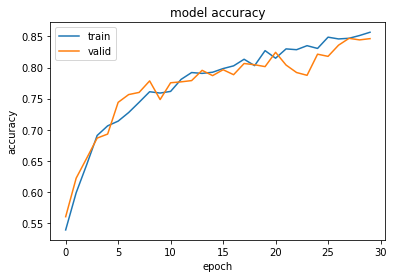

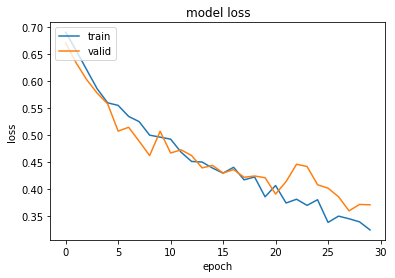

In [63]:
import matplotlib.pyplot as plt

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
"""
#get index for each image in test set
dd = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dd)==np.argmax(test_targets, axis=1))/len(dd)
print('Test accuracy: %f' % test_accuracy)
"""

In [64]:
# evaluate and print test accuracy
score = model.evaluate(test_tensors, test_targets, batch_size=32, verbose=0)
print 'Test accuracy: ' , score[1]*100

Test accuracy:  84.95


In [ ]:
# get predictions on the test set
y_hat = model.predict(test_tensors)

In [ ]:
# plot a random sample of test images, their predicted labels, and ground truth
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, idx in enumerate(np.random.choice(test_tensors.shape[0], size=20, replace=False)):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(test_tensors[idx])
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(test_targets[idx])
    ax.set_title("{} ({})".format(n[pred_idx], n[true_idx]), color=("green" if pred_idx == true_idx else "red"))

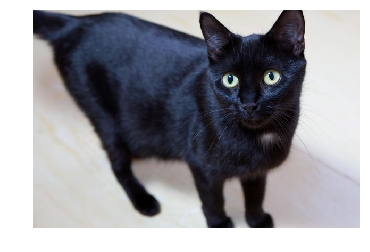

It's a CAT.


In [69]:
from scipy import ndimage
from keras.preprocessing import image  
import matplotlib.image as mpimg

my_image = "xx.jpg"
img=mpimg.imread(my_image)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

img = image.load_img(my_image, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x.astype('float32')/255
y_hat = np.argmax(model.predict(x))

print("It's a {}.".format(n[y_hat])) 